In [134]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

In [107]:
# https://github.com/pytorch/pytorch/issues/47841
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.binom.html
def torch_binom(n, v):
    #mask = n.detach() >= v.detach()
    #n = mask * n
    #v = mask * v
    a = torch.lgamma(n + 1) - torch.lgamma((n - v) + 1) - torch.lgamma(v + 1)
    return torch.exp(a)# * mask

In [108]:
# https://en.wikipedia.org/wiki/Bernstein_polynomial
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BPoly.html
def b(v, n, x):
    return torch_binom(n, v) * x**v * (1 - x)**(n - v)

In [132]:
torch_binom(n=torch.tensor([5]), v=torch.tensor([2]))#10
torch_binom(n=torch.tensor([10]), v=torch.tensor([2]))#45
torch_binom(n=torch.tensor([1]), v=torch.tensor([1]))#1

tensor([1.])

In [109]:
b(v = torch.tensor([2]),
  n = torch.tensor([5]),
  x = torch.tensor([10]))

tensor([-729000.])

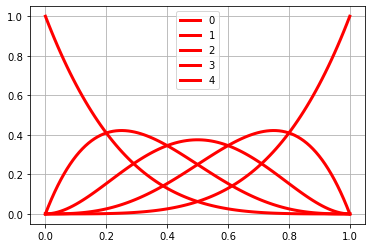

In [228]:
x_space = torch.tensor(np.linspace(0, 1, 100))
n=4

fig, ax = plt.subplots()

for v in range(n+1):
    ax.plot(x_space, b(v = torch.tensor([v]),n = torch.tensor([n]), x = x_space), 'r-', lw=3, label=str(v))

ax.grid(True)
ax.legend(loc='best')
plt.show()

In [79]:
n = torch.tensor([5])
x = torch.tensor([10])
params = torch.tensor([1.5,1.5,1.5,1.5,1.5], requires_grad=True)
true = torch.tensor([1])

prediction = sum(params[v-1] * b(torch.tensor([v]), n, x) for v in range(n+1))

loss = true - prediction

In [317]:
def bernstein_prediction(params, input, degree):
    n = degree
    return sum(params[v-1] * b(torch.FloatTensor([v]), torch.FloatTensor([n]), input) for v in range(n+1))

In [329]:
def bernstein_inverse(params, input, degree):
    n = degree
    k = 1
    return 1 / torch_binom(torch.FloatTensor([n]), torch.FloatTensor([k])) * \
           sum(1 / params[j-1] * torch_binom(torch.FloatTensor([j]), torch.FloatTensor([k])) * b(torch.FloatTensor([j]), torch.FloatTensor([n]), input) for j in range(k,n+1))

In [330]:
x = torch.FloatTensor([1])
p = torch.ones(6,dtype=torch.float)
d = 5

z = bernstein_prediction(params=p, input=x, degree=d)
x_2 = bernstein_inverse(params=p, input=z, degree=d)

x_2

tensor([1.])

In [331]:
x = torch.FloatTensor(np.linspace(0,1,100))
p = torch.FloatTensor([1,2,3,4,5,6])
d = 5

z = bernstein_prediction(params=p, input=x, degree=d)
x_2 = bernstein_inverse(params=p, input=z, degree=d)

In [ ]:
x_2

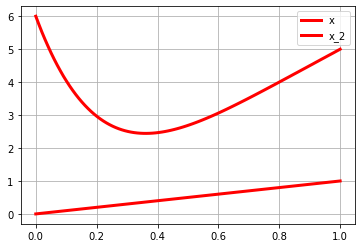

In [332]:
fig, ax = plt.subplots()

ax.plot(x, x, 'r-', lw=3, label="x")
ax.plot(x, x_2, 'r-', lw=3, label="x_2")

ax.grid(True)
ax.legend(loc='best')
plt.show()

In [226]:
5 ** 1

5

In [150]:
torch.FloatTensor([1])

tensor([1.])

In [138]:
list(range(5,10))

[5, 6, 7, 8, 9]

In [84]:
loss.backward()
print(params.grad)

tensor([-328050.,  729000., -810000.,  450000.,  -40951.])


In [80]:
print(loss.grad)

None


In [136]:
np.repeat(0.1,5)

array([0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
class Transformation(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.degree  = torch.FloatTensor(degree).normal_()
        self.params = nn.Parameter(torch.FloatTensor(np.repeat(0.1,degree)))

    def forward(self, input, log_d = 0, inverse = False):
        if not inverse:
            output = bernstein_prediction(self.params, input, self.degree)
            log_d = torch.log(torch.abs(output))
        else:
            z     = (x - self.beta) / self.alpha
            log_d = log_d + torch.log(torch.abs(self.alpha))
        return z, log_d



    def __repr__(self):
        return "Affine(alpha={alpha:.2f}, beta={beta:.2f})".format(alpha = self.alpha[0], beta = self.beta[0])

In [ ]:
class Decorrelation(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.FloatTensor(1).normal_())
        self.beta  = nn.Parameter(torch.FloatTensor(1).normal_())

    def forward(self, x, log_d = 0, inverse = False):
        if not inverse:
            z     = self.alpha * x + self.beta
            log_d = log_d + torch.log(torch.abs(self.alpha))
        else:
            z     = (x - self.beta) / self.alpha
            log_d = log_d + torch.log(torch.abs(self.alpha))
        return z, log_d

    def __repr__(self):
        return "Affine(alpha={alpha:.2f}, beta={beta:.2f})".format(alpha = self.alpha[0], beta = self.beta[0])